# Fill the Matrix 
In this notebook we fill the values of the matrix

In [1]:
from time import time
import psycopg2
from collections import Counter
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True,precision=10)

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from Matrix import convert_matrix

In [3]:
def cleanMatrix(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = "DELETE FROM matrix"
    cur.execute(select_stament)
    conn.commit()
    cur.close()
    conn.close()

In [4]:
def selectWord(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = '''SELECT subject_id,word,isalive 
    FROM subjectwords 
    WHERE (isalive=0 AND LENGTH(word)>15000) OR isalive=1 
    ''' 
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append({'subject_id':row[0],'word':row[1],'isalive':row[2]})
    conn.close()
    return select

In [5]:
def get_all_substrings(input_string,minimun=0,maximun=5):
    substrings = []
    for j in range(len(input_string)) :
        for i in range(minimun,maximun) :
            substring = input_string[j:j+i+1]
            if len(substring)>minimun :
                substrings.append(substring)
    return Counter(substrings)

In [6]:
def saveMatrix(matrix,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement=('INSERT INTO matrix(word,subject_id,counting)'
                      ' SELECT unnest( %(word)s ) ,'
                      ' unnest( %(subject_id)s) ,'
                      ' unnest( %(counting)s)')
    word=[r['word'] for r in matrix]
    subject_id=[r['subject_id'] for r in matrix]
    counting=[r['counting'] for r in matrix]
  #  print(cur.mogrify(insert_statement,locals()))
    cur.execute(insert_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [7]:
def fillMatrix(minimun=0,maximun=5):
    t0 = time()
    cleanMatrix()
    i,lenMatrix=0,0
    for word in selectWord() :
        matrix = []
        subject = word['subject_id']
        subs =get_all_substrings(word['word'],minimun,maximun)
        for key in subs:
            matrix.append({'word':key,'counting':subs[key],'subject_id':subject})
        if matrix!=[]:
            saveMatrix(matrix)
        lenMatrix=lenMatrix+len(matrix)
    print("The matrix was filled with "+str(lenMatrix)+" values.")
    print("fillMatrix done in %0.3fs." % (time() - t0))

In [8]:
def fixMatrix(dbname="mimic") :
    t0 = time()
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    def executeDelete(cur,conn,select_stament):
        cur.execute(select_stament)
        conn.commit()
    repeated_words = ("DELETE FROM matrix WHERE word "
                      "IN (SELECT word FROM matrix GROUP BY word HAVING sum(counting)<5)")
    executeDelete(cur,conn,repeated_words)
    select_stament = ("DELETE FROM matrix WHERE subject_id "
                      "IN (SELECT subject_id FROM matrix GROUP BY subject_id HAVING sum(counting)<10)"
    )
    executeDelete(cur,conn,select_stament)
    select_stament = '''DELETE FROM matrix WHERE word 
    IN (SELECT word FROM matrix group by word HAVING count(1)>=(
    SELECT count(distinct subject_id) FROM matrix)*.95)
    '''
    executeDelete(cur,conn,select_stament)
    executeDelete(cur,conn,repeated_words)
    cur.close()
    conn.close()
    print("fixMatrix done in %0.3fs." % (time() - t0))

In [9]:
def heartBeatDeads(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = '''SELECT DISTINCT word FROM matrix 
    WHERE subject_id IN (SELECT subject_id FROM subjectwords WHERE isalive=1)'''
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append(row[0])
    cur.close()
    conn.close()
    print(len(select))
    return select

In [10]:
def deleteOnlyAlive(heardBeatDeads,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = "DELETE FROM matrix WHERE word in %s"
#    print(cur.mogrify(select_stament,(heardBeatDeads,)))
    cur.execute(select_stament,(heardBeatDeads,))
    conn.commit()
    cur.close()
    conn.close()

In [11]:
def printSurvivor(survived):
    labels = 'Viven', 'Mueren'
    sizes = [survived.count(0),survived.count(1)]
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
        return my_autopct
    plt.title("Número de pacientes "+str(sum(sizes)))
    plt.pie(sizes, labels=labels, autopct=make_autopct(sizes),
            shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

## llenado de la matriz con palabras entre un maximo y un minimo

In [12]:
fillMatrix(minimun=2,maximun=8)

The matrix was filled with 2093564 values.
fillMatrix done in 58.569s.


In [13]:
fixMatrix()

fixMatrix done in 100.744s.


In [14]:
#deadBeats = heartBeatDeads()
#deleteOnlyAlive(tuple(deadBeats))

In [15]:
table = convert_matrix()
table

(590, 58840)


,,aaaaaaa,aaaaaaaa,aaaaaaab,aaaaaaac,aaaaaaad,aaaaaaae,aaaaaaaf,aaaaaaag,aaaaaaah,aaaaaaai,...,kkb,kke,lab,lbb,lbbb,lbbc,lcc,leb,lib,libb
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
20,0,13240,12915,305,0,17,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,1,12566,11931,613,0,17,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,4297,3722,512,2,61,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,1,7298,7209,75,0,8,0,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
214,1,10087,9776,213,1,52,0,34,9,0,0,...,0,0,0,0,0,0,0,0,0,0
263,1,12094,12066,23,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,47,24,19,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283,1,33,23,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368,1,4315,4027,245,39,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


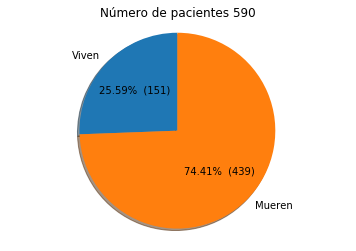

In [16]:
printSurvivor(table.index.labels[1].tolist())

In [17]:
def findAverage(table):
    numRegs,count = 0,0
    for value in table.columns:
        total = table[value].sum()
        numRegs += total
        count +=1
    average =int(numRegs/count)
    print(numRegs,count,"average",average)
    return average

In [18]:
def findOverAverage(table):
    count=0
    underaverage = []
    average=findAverage(table)
    for value in table.columns:
        total = table[value].sum()
        if total>average:
            underaverage.append(value)
            count+=1
#            print("%s:%d" %(value,total,),end="|")
    return underaverage

In [19]:
#over_average = findOverAverage(table)
#deleteOnlyAlive(tuple(over_average))

In [20]:
table = convert_matrix()
table

(590, 58840)


,,aaaaaaa,aaaaaaaa,aaaaaaab,aaaaaaac,aaaaaaad,aaaaaaae,aaaaaaaf,aaaaaaag,aaaaaaah,aaaaaaai,...,kkb,kke,lab,lbb,lbbb,lbbc,lcc,leb,lib,libb
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
20,0,13240,12915,305,0,17,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,1,12566,11931,613,0,17,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,4297,3722,512,2,61,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,1,7298,7209,75,0,8,0,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
214,1,10087,9776,213,1,52,0,34,9,0,0,...,0,0,0,0,0,0,0,0,0,0
263,1,12094,12066,23,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,47,24,19,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283,1,33,23,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368,1,4315,4027,245,39,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


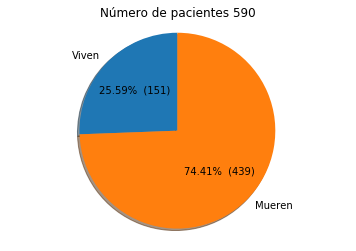

In [21]:
printSurvivor(table.index.labels[1].tolist())